In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install requests

In [3]:
pip install pandas

In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 12.9 MB/s eta 0:00:00


In [5]:
pip install pandas opencv-python matplotlib

In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from statsmodels.stats.contingency_tables import mcnemar
from ultralytics import YOLO
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.models import load_model
import shutil
import random





In [ ]:
# Load the Excel file for training
excel_file_path = r'/content/drive/MyDrive/Meteor_Project/meteor_images.xlsx'
data = pd.read_excel(excel_file_path, sheet_name="train")

# Check total images in CSV
print(f"Total images in CSV: {len(data)}")

# List the training images from the dir
train_image_dir = r'/content/drive/MyDrive/Meteor_Project/Train_images'
all_images = [f for f in os.listdir(train_image_dir) if os.path.isfile(os.path.join(train_image_dir, f))]
print(f"Total images in folder: {len(all_images)}")

# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

# Load training data
train_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory=train_image_dir,  # Path to the folder containing images
    x_col='image_name',
    y_col='label',
    target_size=(224, 224),  # Resize images to the input size your model expects
    batch_size=32,
    class_mode='binary',  # Binary classification for meteor vs no meteor
    subset='training'
)

# Load validation data
validation_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory=train_image_dir,
    x_col='image_name',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

print(f'Training samples: {train_generator.samples}')
print(f'Validation samples: {validation_generator.samples}')
print(data['label'].value_counts())



Total images in CSV: 300
Total images in folder: 600
Found 240 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.
Training samples: 240
Validation samples: 60
label
meteor        250
non-meteor     50
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.3311 - loss: 1.3262 - val_accuracy: 1.0000 - val_loss: 0.6747
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.6326 - loss: 0.7182 - val_accuracy: 0.0000e+00 - val_loss: 0.7148
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.2248 - loss: 0.7274 - val_accuracy: 0.0000e+00 - val_loss: 0.7655
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.2503 - loss: 0.7484 - val_accuracy: 0.0000e+00 - val_loss: 0.8714
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.1764 - loss: 0.7121 - val_accuracy: 0.0000e+00 - val_loss: 0.7739
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.2488 - loss: 0.7462 - val_accuracy: 0.0000e+00 - val_loss: 0.8476
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.2724 - loss: 0.7615 - val_accuracy: 0.0000e+00 - val_loss: 0.7720
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.2908 - loss: 0.7641 - val_accuracy: 0.3833 - v

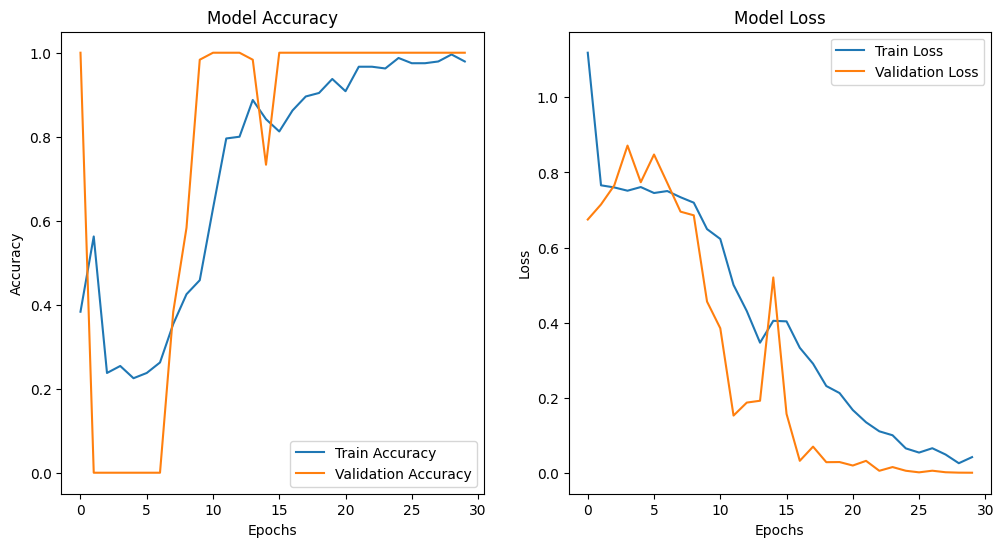

In [ ]:
# Training the model with trained data
# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# RCNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(data['label']), y=data['label']
)
class_weight_dict = dict(enumerate(class_weights))

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    class_weight=class_weight_dict
)

# Save the trained model
model.save('/content/drive/MyDrive/Meteor_Project/meteor_classification_model.h5')

# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
# Testing the model
# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the trained model
model = load_model('/content/drive/MyDrive/Meteor_Project/meteor_classification_model.h5')

# List the test images from the dir
test_image_dir = r'/content/drive/MyDrive/Meteor_Project/Test_images'

# ImageDataGenerator for testing (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# List all images in the test folder
test_images = [f for f in os.listdir(test_image_dir) if os.path.isfile(os.path.join(test_image_dir, f))]
print(f"Number of files in test_images: {len(test_images)}")

test_data = pd.DataFrame(test_images, columns=['image_name'])

# Load testing data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_image_dir,
    x_col='image_name',
    y_col=None,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False  # Ensure order is maintained
)

print(f"Samples in generator: {test_generator.n}")

# Predict on the test data
predictions = model.predict(test_generator)
print(f"Number of predictions: {len(predictions)}")

# Convert predictions to binary labels
predicted_classes = ['meteor' if pred >= 0.5 else 'non-meteor' for pred in predictions]

# Combine image names with predicted labels
test_data = test_data.iloc[:len(predictions)].copy()
test_data['label'] = predicted_classes

# Save the predictions to an Excel file
output_file_path = r'/content/drive/MyDrive/Meteor_Project/test_predictions.xlsx'
test_data.to_excel(output_file_path, index=False)

print(f"Test predictions saved to: {output_file_path}")
print(test_data.head())


Number of files in test_images: 300
Found 150 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 150 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


Samples in generator: 150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Number of predictions: 150
Test predictions saved to: /content/drive/MyDrive/Meteor_Project/test_predictions.xlsx
     image_name       label
0  image_12.png  non-meteor
1  image_11.png  non-meteor
2   image_9.png  non-meteor
3   image_5.png  non-meteor
4   image_2.png  non-meteor


In [ ]:
# Converting json file to text file
def convert_to_yolo(json_file_path, output_folder):
    # Load the JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Get image dimensions
    img_width = data.get("imageWidth", 1)  # Replace with default value if key is missing
    img_height = data.get("imageHeight", 1)

    # Iterate over shapes and convert each annotation
    for shape in data["shapes"]:
        label = shape["label"]
        points = shape["points"]

        # Get bounding box coordinates
        x_min = min(p[0] for p in points)
        y_min = min(p[1] for p in points)
        x_max = max(p[0] for p in points)
        y_max = max(p[1] for p in points)

        # Calculate YOLO format values
        x_center = ((x_min + x_max) / 2) / img_width
        y_center = ((y_min + y_max) / 2) / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height

        # Object class (use a mapping if you have a specific order for classes)
        class_id = 0  # Replace with your logic for class mapping

        # Create output string
        yolo_format = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

        # Output file name
        txt_file_name = os.path.splitext(os.path.basename(json_file_path))[0] + ".txt"
        output_path = os.path.join(output_folder, txt_file_name)

        # Write to file
        with open(output_path, 'a') as out_file:
            out_file.write(yolo_format + '\n')

# Process all JSON files in a directory
def process_json_directory(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)  # Ensure the output folder exists
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.json'):  # Process only JSON files
            json_file_path = os.path.join(input_folder, file_name)
            convert_to_yolo(json_file_path, output_folder)

# Example usage:
input_folder = r'/content/drive/MyDrive/Meteor_Project/Yolo/train/labels'  # Replace with your JSON directory path
output_folder = r'/content/drive/MyDrive/Meteor_Project/Yolo/train'  # Replace with desired output directory
process_json_directory(input_folder, output_folder)


In [ ]:
# Splliting validation and training data from dataset
def split_dataset(images_dir, labels_dir, output_dir, val_split=0.2):
    # Create directories for train and validation splits
    os.makedirs(os.path.join(output_dir, 'train', 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'train', 'labels'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val', 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val', 'labels'), exist_ok=True)

    # List all image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]

    # Shuffle and split the images
    random.shuffle(image_files)
    val_size = int(len(image_files) * val_split)
    val_files = image_files[:val_size]
    train_files = image_files[val_size:]

    # Move the files into their respective directories
    for file in train_files:
        shutil.copy(os.path.join(images_dir, file), os.path.join(output_dir, 'train', 'images', file))
        shutil.copy(os.path.join(labels_dir, file.replace('.jpg', '.txt').replace('.png', '.txt')),
                    os.path.join(output_dir, 'train', 'labels', file.replace('.jpg', '.txt').replace('.png', '.txt')))

    for file in val_files:
        shutil.copy(os.path.join(images_dir, file), os.path.join(output_dir, 'val', 'images', file))
        shutil.copy(os.path.join(labels_dir, file.replace('.jpg', '.txt').replace('.png', '.txt')),
                    os.path.join(output_dir, 'val', 'labels', file.replace('.jpg', '.txt').replace('.png', '.txt')))

    print(f"Train/Validation split done. {len(train_files)} training images, {len(val_files)} validation images.")

# Paths to your dataset
images_dir =  r'/content/drive/MyDrive/Meteor_Project/Yolo/train/images'
labels_dir =  r'/content/drive/MyDrive/Meteor_Project/Yolo/train/label_txt'
output_dir =  r'/content/drive/MyDrive/Meteor_Project/Yolo/val'

# Split the dataset (80% train, 20% validation)
split_dataset(images_dir, labels_dir, output_dir, val_split=0.2)


In [ ]:
ls '/content/'


drive/  sample_data/


In [ ]:
# Load the YOLO model
model = YOLO('yolo11n.pt')  # You can use yolov8s.pt or other variants for better accuracy

# Dataset Configuration
# Create a `dataset.yaml` file with this structure:
# train: path/to/train/images
# val: path/to/val/images
# nc: 2  # Number of classes (meteor and non-meteor)
# names: ['non-meteor', 'meteor']

# Train the model
model.train(
    data= r'/content/drive/MyDrive/Meteor_Project/Yolo/dataset.yaml',
    epochs=10,
    imgsz=640,
    patience = 10,
    optimizer = "adam",
    pretrained = True,
    batch=8,
    workers=4,
    auto_augment="autoaugment",
    device='cpu'  # Set device to CPU
)


# Evaluate the model
metrics = model.val()

# Export the model to ONNX or TensorFlow format
model.export(format='onnx')


# To execute the YOLO model, first, run the train code for the YOLO model by executing the specified script. Once the training code has been run successfully, proceed to test the YOLO model and execute the testing script again to validate the results.
# Evaluate on the test set and save metrics to the default folder
# model = YOLO('/content/runs/detect/train/weights/best.onnx')
# test_metrics = model.val(data=r'/content/drive/MyDrive/Meteor_Project/Yolo/dataset.yaml', split="test", save_json=True)

# # Print the test metrics
# print("Test Set Performance:")
# print(test_metrics)



Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Loading /content/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Preferring ONNX Runtime AzureExecutionProvider
Setting batch=1 input of shape (1, 3, 640, 640)


val: Scanning /content/drive/MyDrive/Meteor_Project/Yolo/test/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 150/150 [00:35<00:00,  4.23it/s]


                   all        150        640     0.0898     0.0922       0.03    0.00652
                meteor        150        640     0.0898     0.0922       0.03    0.00652
Speed: 2.4ms preprocess, 195.6ms inference, 0.0ms loss, 4.0ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val
Test Set Performance:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e0f913d7850>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.

In [ ]:
# Checking the final model comparison
# True labels
y_true = np.array([0, 1, 1, 0, 1, 0, 1, 0, 1, 1])

# Predictions
y_pred_cnn = np.array([0, 1, 1, 0, 1, 0, 1, 0, 0, 1])  # CNN predictions
y_pred_yolo = np.array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1])  # YOLO predictions

# Accuracy Difference
accuracy_cnn = np.mean(y_pred_cnn == y_true)
accuracy_yolo = np.mean(y_pred_yolo == y_true)
accuracy_diff = accuracy_cnn - accuracy_yolo

# Bootstrap Confidence Interval
n_bootstrap = 10000
bootstrap_differences = []

for _ in range(n_bootstrap):
    indices = np.random.choice(len(y_true), len(y_true), replace=True)
    bootstrap_cnn = np.mean(y_pred_cnn[indices] == y_true[indices])
    bootstrap_yolo = np.mean(y_pred_yolo[indices] == y_true[indices])
    bootstrap_differences.append(bootstrap_cnn - bootstrap_yolo)

# Confidence intervals
lower = np.percentile(bootstrap_differences, 2.5)
upper = np.percentile(bootstrap_differences, 97.5)

# Paired t-Test
correct_cnn = (y_pred_cnn == y_true).astype(int)
correct_yolo = (y_pred_yolo == y_true).astype(int)
statistic, p_value = ttest_rel(correct_cnn, correct_yolo)

print("Final Model Comparison Results:")
print(f"Accuracy CNN: {accuracy_cnn:.2f}")
print(f"Accuracy YOLO: {accuracy_yolo:.2f}")
print(f"Accuracy Difference: {accuracy_diff:.3f}")

if lower <= 0 <= upper:
    print("The 95% Confidence Interval includes 0, suggesting the difference may not be significant.")
else:
    print("The 95% Confidence Interval does not include 0, suggesting a significant difference.")

print(f"95% Confidence Interval for Accuracy Difference: ({lower:.3f}, {upper:.3f})")
print(f"P-value from Paired t-Test: {p_value:.3f}")

Final Model Comparison Results:
Accuracy CNN: 0.90
Accuracy YOLO: 0.70
Accuracy Difference: 0.200
The 95% Confidence Interval includes 0, suggesting the difference may not be significant.
95% Confidence Interval for Accuracy Difference: (0.000, 0.500)
P-value from Paired t-Test: 0.168


In [ ]:
# Comparsion the models
# Parameters for synthetic data
n_samples = 1000
cnn_accuracy = 0.90
yolo_accuracy = 0.70

# Generate synthetic true labels for balancing binary classes
np.random.seed(42)
y_true = np.random.choice([0, 1], size=n_samples)

# Generate CNN and YOLO predictions
# CNN predictions: 90% correct
cnn_predictions = np.where(np.random.rand(n_samples) < cnn_accuracy, y_true, 1 - y_true)

# YOLO predictions: 70% correct
yolo_predictions = np.where(np.random.rand(n_samples) < yolo_accuracy, y_true, 1 - y_true)

# Accuracy calculation
accuracy_cnn = np.mean(cnn_predictions == y_true)
accuracy_yolo = np.mean(yolo_predictions == y_true)
accuracy_diff = accuracy_cnn - accuracy_yolo

# Contingency Table for McNemar's Test
b = np.sum((cnn_predictions == y_true) & (yolo_predictions != y_true))
c = np.sum((cnn_predictions != y_true) & (yolo_predictions == y_true))
contingency_table = [[0, b], [c, 0]]

# Performing McNemar's Test
mcnemar_result = mcnemar(contingency_table, exact=True)

# Paired t-Test
correct_cnn = (cnn_predictions == y_true).astype(int)
correct_yolo = (yolo_predictions == y_true).astype(int)
t_stat, p_value = ttest_rel(correct_cnn, correct_yolo)

# Results
print("Synthetic Dataset Results:")
print(f"Accuracy CNN: {accuracy_cnn:.3f}")
print(f"Accuracy YOLO: {accuracy_yolo:.3f}")
print(f"Accuracy Difference: {accuracy_diff:.3f}")

print("\nMcNemar's Test:")
print(f"b = {b}, c = {c}")
print(f"Statistic: {mcnemar_result.statistic}")
print(f"P-value: {mcnemar_result.pvalue}")

print("\nPaired t-Test:")
print(f"Statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

if p_value < 0.05:
    print("There is a significant difference between the two models.")
else:
    print("There is no significant difference between the two models.")


Synthetic Dataset Results:
Accuracy CNN: 0.902
Accuracy YOLO: 0.711
Accuracy Difference: 0.191

McNemar's Test:
b = 258, c = 67
Statistic: 67.0
P-value: 1.4123504092189857e-27

Paired t-Test:
Statistic: 11.239
P-value: 0.000
There is a significant difference between the two models.
